# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider $N$ customers whose connection phase assumes one out of three possible labels $a$, $b$, or $c$ and estimate the correct customer-to-label assignment based on $M$ readings whose per-phase values are a function of the corresponding phase-connected individual customer reading.

Considered network
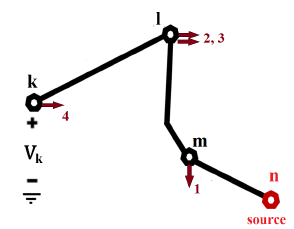

<b>Import Python Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parameters

In [77]:
cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.00

<b>Initial data

In [78]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow




<b>Power Flow Function

In [79]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp;
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration


<b> Compute the values of voltages obtained by PMUs

In [80]:
#Creation of Matrices
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
v=np.zeros((m,3))
dv_abs=np.zeros((m,3))


for i in range(m):
    si=[[0, 0, s[i,2], 0],[0, 0, s[i,1], 0],[0, s[i,0],  0, s[i,3]]] #Connection of consumers by
                                                                     #node and by phase
                                                                     #Consumer 1 (s[i,0]) is 
                                                                     #connected to Bus 2 in Phase 3
    mvp=pf3ph(topo,z,si,vr,el,ni,al)
    noise=1+noiseFactor*np.random.randn(3)
    mvp[:,3]=np.multiply(mvp[:,3],noise)                       #Add noise to the voltages
    Y[3*(i):3*(i)+3]=mvp[:,3]                                  #Save the voltages in matrix Y
    dv_abs[i,:]=vr-np.abs(mvp[:,3])                            #Voltage variations (only to plot)

Volt=np.reshape(Y,(m,3))   

print ('The voltages measured in the PMUs are:\n',Volt)


The voltages measured in the PMUs are:
 [[ 0.99866484-0.00476962j -0.49831414-0.86835917j -0.49392011+0.85964588j]
 [ 0.97290228-0.01601085j -0.51139766-0.87380016j -0.50744349+0.85456696j]
 [ 0.95608633-0.02441701j -0.51885398-0.87750207j -0.51325967+0.84910673j]
 [ 1.04767033-0.03551787j -0.45091668-0.89757332j -0.40102796+0.79332501j]
 [ 1.01576499-0.00999985j -0.48302166-0.87236861j -0.46567302+0.84426734j]
 [ 1.00968654-0.00695356j -0.48918564-0.87063669j -0.47774451+0.85167455j]
 [ 1.00602188-0.005418j   -0.49284148-0.869901j   -0.48483326+0.85566688j]
 [ 1.00423842-0.00571336j -0.4939299 -0.86980129j -0.48633757+0.85598497j]
 [ 1.00578779-0.00995392j -0.4910006 -0.87340185j -0.4790803 +0.84942259j]
 [ 1.0006834 -0.00538471j -0.49631931-0.86845387j -0.49010362+0.8577634j ]
 [ 1.00475844-0.00282624j -0.4936193 -0.86480633j -0.48660002+0.8589564j ]
 [ 1.00631448-0.00319825j -0.49244873-0.86549546j -0.48460471+0.85781421j]]


<b> Sum of Impedences
    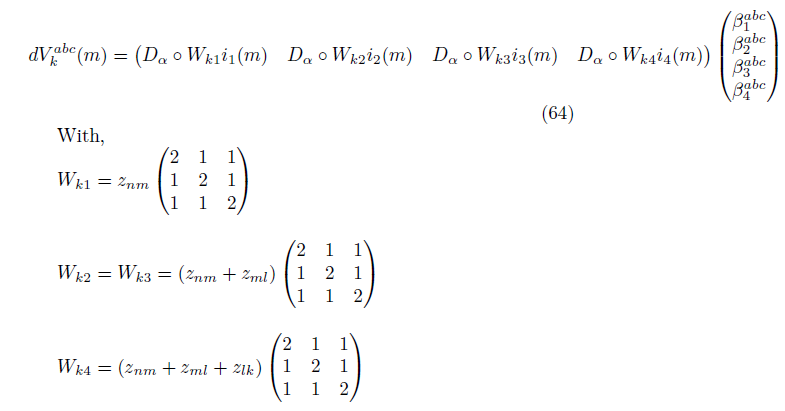

In [81]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm;z_ml and zlk
Z=[[2, al, al**2],[1, 2*al, al**2],[1, al, 2*al**2]]
Z


[[2,
  (-0.4999999999999998-0.8660254037844387j),
  (-0.5000000000000003+0.8660254037844384j)],
 [1,
  (-0.9999999999999996-1.7320508075688774j),
  (-0.5000000000000003+0.8660254037844384j)],
 [1,
  (-0.4999999999999998-0.8660254037844387j),
  (-1.0000000000000007+1.7320508075688767j)]]

<b>Complex Expansion
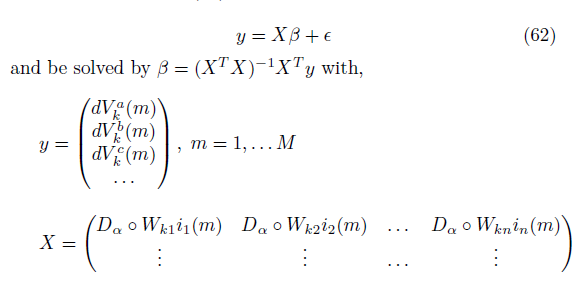

In [93]:

vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

#Compute dVk for each time period m   
#dvk is the yk vector in the paper (Please use the value Y)
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info


# Compute X matrix considering different W (Please use the value Z)
for i in range(m):
    X[3 * i: 3 * i + 3, i] = np.matmul(Z, s[i, :3])


# Betas with PMUs info
Bpmu = np.linalg.inv(X.T @ X) @ X.T @ vz

# Betas with RTUs info
Brtu = np.linalg.inv(X.T @ X) @ X.T @ vz_abs

Bpmu_real = np.real(Bpmu)
Brtu_real = np.real(Brtu)

list_phases_pmu = []
list_phases_rtu = []
for i in range(len(Bpmu_real)//3):
    # person_phase will be the index of the maximum value of the three phases, from 1 to 3
    person_phase_pmu = np.argmax(Bpmu_real[3*i:3*i+3]) + 1
    person_phase_rtu = np.argmax(Brtu_real[3*i:3*i+3]) + 1
    list_phases_pmu.append(person_phase_pmu)
    list_phases_rtu.append(person_phase_rtu)

# print betas
print("BPMU: ", Bpmu)
print("BRTU: ", Brtu)
print('\n')
# print which phase each person had
print("PMU: ", list_phases_pmu)
print("RTU: ", list_phases_rtu)

BPMU:  [ 0.06944991+0.15493764j  0.00993353-0.04827363j  0.00922206-0.05023336j
 -1.15490817+0.44181532j -0.1443528 +0.05723589j -0.03219555+0.01879856j
 -0.023016  +0.01651082j -0.01880343+0.01699719j -0.01571437+0.01738075j
 -0.01273884+0.01901405j -0.0281142 +0.00832568j -0.0592904 +0.01396896j]
BRTU:  [ 1.65938521e-02+0.16919602j  3.56572484e-03-0.02170219j
  5.66254611e-04-0.02001142j -6.79048963e-01-0.13355911j
 -9.61497165e-02+0.01849404j -2.03732229e-02+0.01025938j
 -1.43350907e-02+0.00892365j -1.17140916e-02+0.00869388j
 -9.63216494e-03+0.00877663j -8.36691797e-03+0.00813988j
 -1.89471878e-02+0.00427899j -4.07185145e-02+0.00468046j]


PMU:  [1, 3, 3, 1]
RTU:  [1, 3, 3, 1]


<b>Graphics

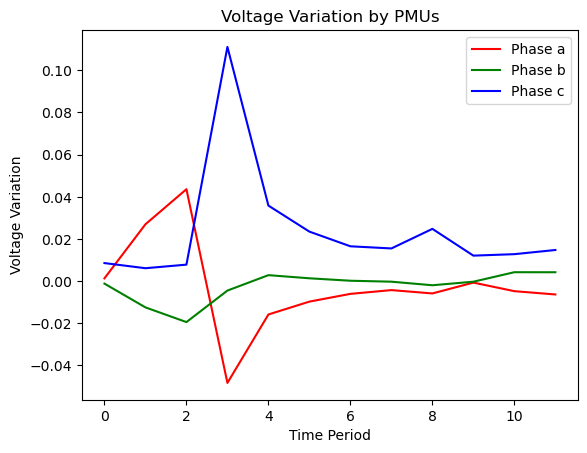

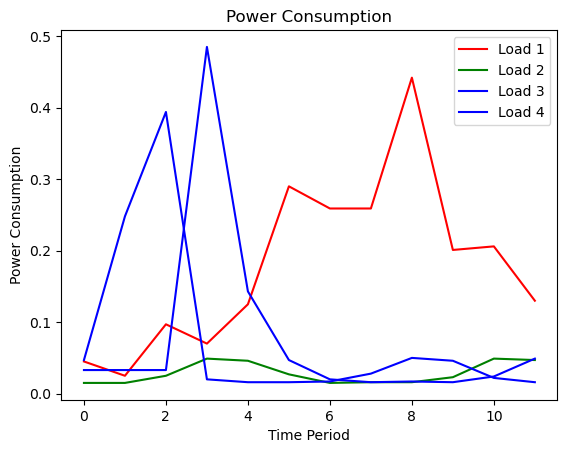

In [83]:
import matplotlib.pyplot as plt

# Specify the data to plot
x = np.arange(m)
y1 = dv_abs
y2 = s[0:12,:]


# Graph 1
plt.figure()
plt.title("Voltage Variation by PMUs")
plt.plot(x, y1[:, 0], 'r', label='Phase a')
plt.plot(x, y1[:, 1], 'g', label='Phase b')
plt.plot(x, y1[:, 2], 'b', label='Phase c')
plt.xlabel("Time Period")
plt.ylabel("Voltage Variation")
plt.legend()
plt.show()

# Graph 2
plt.figure()
plt.title("Power Consumption")
plt.plot(x, y2[:, 0], 'r', label='Load 1')
plt.plot(x, y2[:, 1], 'g', label='Load 2')
plt.plot(x, y2[:, 2], 'b', label='Load 3')
plt.plot(x, y2[:, 3], 'b', label='Load 4')
plt.xlabel("Time Period")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

# Show the plots
plt.show()

In [84]:
"""
import numpy as np

def add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):
    X_intermittent = X.copy()
    num_customers, num_periods = X.shape
    num_intermittent = int(p_intermittent * num_customers)
    
    for i in range(num_intermittent):
        customer_idx = np.random.randint(num_customers)
        time_idx = np.random.randint(num_periods)
        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]
    
    return X_intermittent

X_intermittent = add_intermittent_loads(X)

# Now, use X_intermittent in the phase identification process and compare the results with the original X.

"""

'\nimport numpy as np\n\ndef add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):\n    X_intermittent = X.copy()\n    num_customers, num_periods = X.shape\n    num_intermittent = int(p_intermittent * num_customers)\n    \n    for i in range(num_intermittent):\n        customer_idx = np.random.randint(num_customers)\n        time_idx = np.random.randint(num_periods)\n        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]\n    \n    return X_intermittent\n\nX_intermittent = add_intermittent_loads(X)\n\n# Now, use X_intermittent in the phase identification process and compare the results with the original X.\n\n'